<a href="https://colab.research.google.com/github/maedeamooshahi/big-4/blob/main/Copy_of_Untitled17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install handyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 38 kB/s 
     |████████████████████████████████| 198 kB 38.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=6312008d1e30ec320c6417f4dc58d7903b4335ec852b23f6bfa4e720ec2cfdb4
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master('local[*]').getOrCreate()

In [ ]:
import pyspark
from pyspark.ml.feature import StringIndexer
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import *
from pyspark.sql import Row
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [ ]:
data=spark.read.csv('/content/data.csv',inferSchema=True, header=True)
data.show(10)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Label|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|5331-RGMTT|  Male|          1.0|    Yes|        No|  54.0|  

In [ ]:
data_Pro_1=data.drop('PaperlessBilling','Dependents')
print("Size of data is:" , data_Pro_1.count())
print("the data is:")
data_Pro_1.show(10)

Size of data is: 229990
the data is:
+----------+------+-------------+-------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|       PaymentMethod|MonthlyCharges|TotalCharges|Label|
+----------+------+-------------+-------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+--------------------+--------------+------------+-----+
|5331-RGMTT|  Male|          1.0|    Yes|  54.0|         Yes|             Yes|    Fiber optic|              

In [ ]:
data_Pro_2 = data_Pro_1.filter(data_Pro_1.customerID.isNotNull())
data_Pro_2 = data_Pro_2.filter(data_Pro_2.Label.isNotNull())
print("Number of deleted data with null customerID.")
print("Size of data is: ", data_Pro_2.count())
data_Pro_2.show(10)

Number of deleted data with null customerID.
Size of data is:  229589
+----------+------+-------------+-------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|       PaymentMethod|MonthlyCharges|TotalCharges|Label|
+----------+------+-------------+-------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+--------------------+--------------+------------+-----+
|5331-RGMTT|  Male|          1.0|    Yes|  54.0|         Yes|             Y

In [ ]:
from pyspark.sql.functions import col,isnan, when, count
null_df = data_Pro_2.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '') | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in data_Pro_2.columns])
null_df.show()

+----------+------+-------------+-------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+-------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaymentMethod|MonthlyCharges|TotalCharges|Label|
+----------+------+-------------+-------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+-------------+--------------+------------+-----+
|         0|   123|          130|    106|   109|         133|          132|            119|           115|         128|             129|        138|        120|            114|     110|          133|           131|         122|    0|
+----------+------+-------------+-------+------+------------+---

In [ ]:

TotalCharges_mean = data_Pro_2.select(["TotalCharges"]).toPandas().mean()[0]
print("min of TotalCharges columns is:",TotalCharges_mean)
data_Pro_2 = data_Pro_2.na.fill( TotalCharges_mean,subset='TotalCharges')

MonthlyCharges_mean = data_Pro_2.select(["MonthlyCharges"]).toPandas().mean()[0]
print("min of MonthlyCharges_mean columns is:",MonthlyCharges_mean)
data_Pro_2 = data_Pro_2.na.fill( MonthlyCharges_mean,subset='MonthlyCharges')

tenure_mean = data_Pro_2.select(["tenure"]).toPandas().mean()[0]
print("min of MonthlyCharges_mean columns is:",tenure_mean)
data_Pro_2 = data_Pro_2.na.fill(tenure_mean,subset='tenure')
print("the data next with avg:\n")
data_Pro_2.show(10)

min of TotalCharges columns is: 3701.7594560437465
min of MonthlyCharges_mean columns is: 126.42422251567098
min of MonthlyCharges_mean columns is: 49.436085933414674
the data next with avg:

+----------+------+-------------+-------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|       PaymentMethod|MonthlyCharges|TotalCharges|Label|
+----------+------+-------------+-------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+---------

In [ ]:
from pyspark.sql.functions import col,isnan, when, count
null_df = data_Pro_2.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '') | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in data_Pro_2.columns])
null_df.show()

+----------+------+-------------+-------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+-------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaymentMethod|MonthlyCharges|TotalCharges|Label|
+----------+------+-------------+-------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+-------------+--------------+------------+-----+
|         0|   123|          130|    106|     0|         133|          132|            119|           115|         128|             129|        138|        120|            114|     110|          133|             0|           0|    0|
+----------+------+-------------+-------+------+------------+---

In [ ]:
data.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: double (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: double (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Label: string (nullable = true)



In [ ]:
from handyspark import *
indexer= StringIndexer(inputCol="Label", outputCol="Label_index").fit(data)
data_Pre2 = indexer.transform(data)
indexer= StringIndexer(inputCol="Contract", outputCol="Contract_index").fit(data_Pro_2)
data_Pre2 = indexer.transform(data_Pre2)
hdf = data_Pre2.toHandy()
hdf.show(5)

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+-----------+--------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Label|Label_index|Contract_index|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+-----------+--------------+
|5331-RGMTT|  Male|          1.0|    Yes|        No|  54.0|         Yes|          Yes|    Fibe

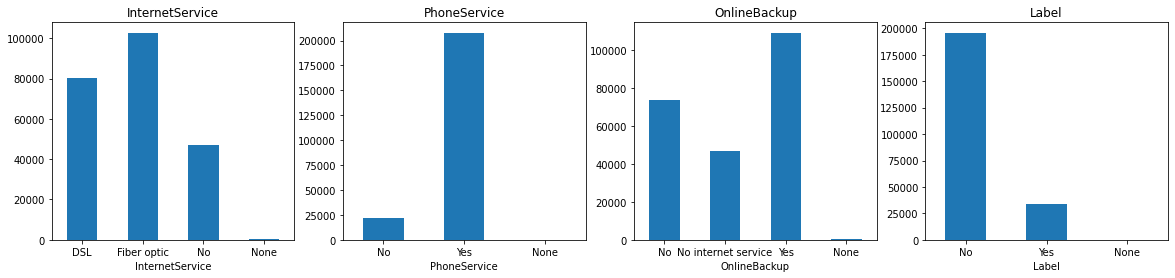

In [ ]:
from matplotlib import pyplot as plt
fig, axs = plt.subplots(1, 4, figsize=(20, 4))
hdf.cols['InternetService'].hist(ax=axs[0])
hdf.cols['PhoneService'].hist(ax=axs[1])
hdf.cols['OnlineBackup'].hist(ax=axs[2])
hdf.cols['Label'].hist(ax=axs[3])

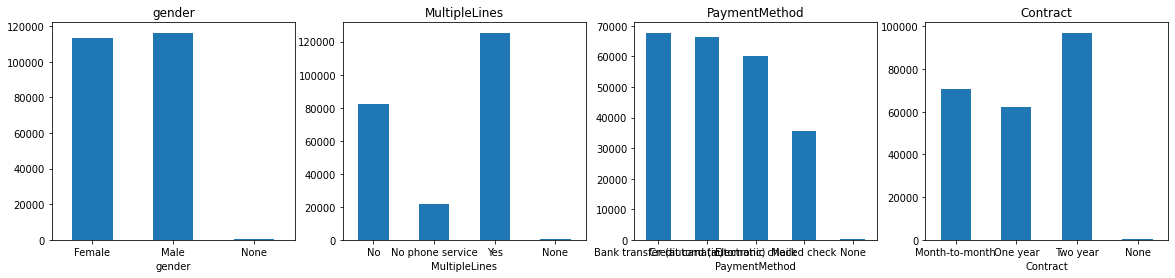

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(20, 4))
hdf.cols['gender'].hist(ax=axs[0])
hdf.cols['MultipleLines'].hist(ax=axs[1])
hdf.cols['PaymentMethod'].hist(ax=axs[2])
hdf.cols['Contract'].hist(ax=axs[3])

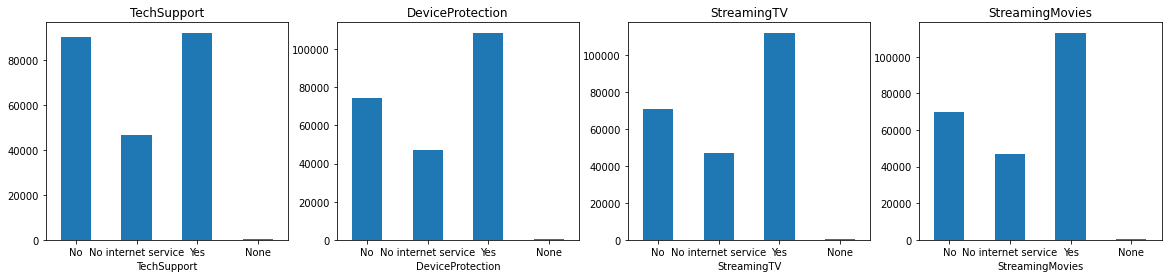

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(20, 4))
hdf.cols['TechSupport'].hist(ax=axs[0])
hdf.cols['DeviceProtection'].hist(ax=axs[1])
hdf.cols['StreamingTV'].hist(ax=axs[2])
hdf.cols['StreamingMovies'].hist(ax=axs[3])

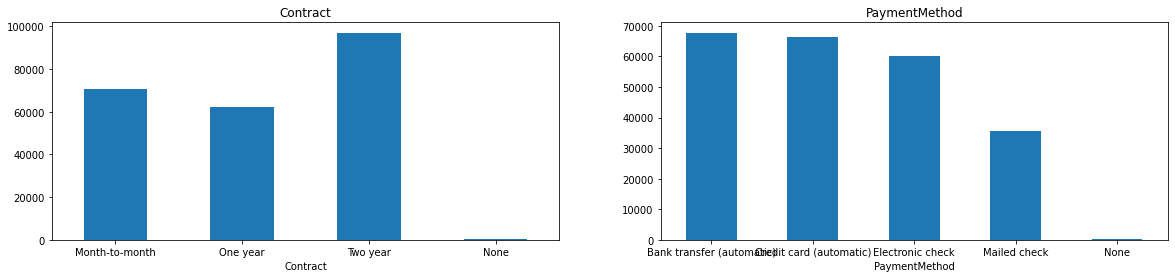

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 4))
hdf.cols['Contract'].hist(ax=axs[0])
hdf.cols['PaymentMethod'].hist(ax=axs[1])

(<Figure size 576x432 with 2 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7f5cf50dd050>])

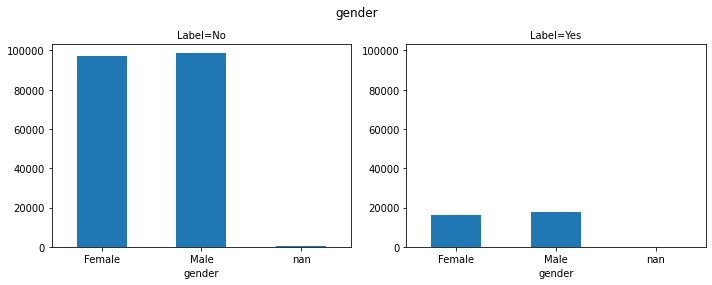

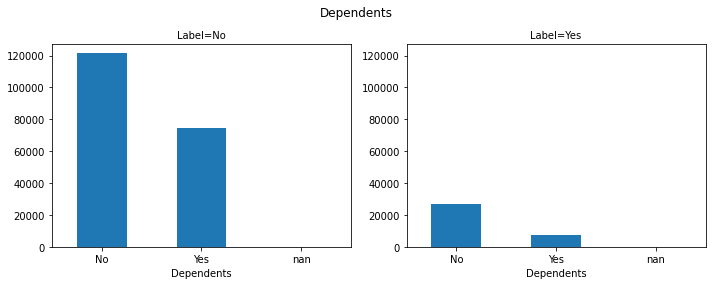

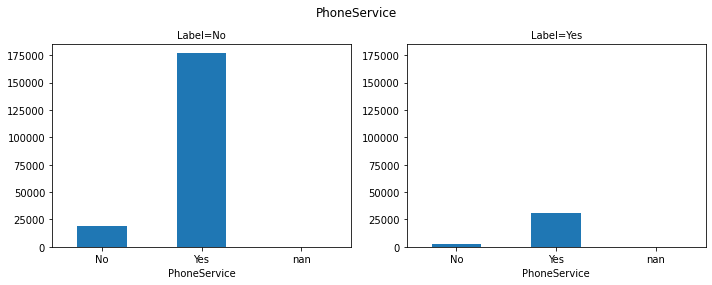

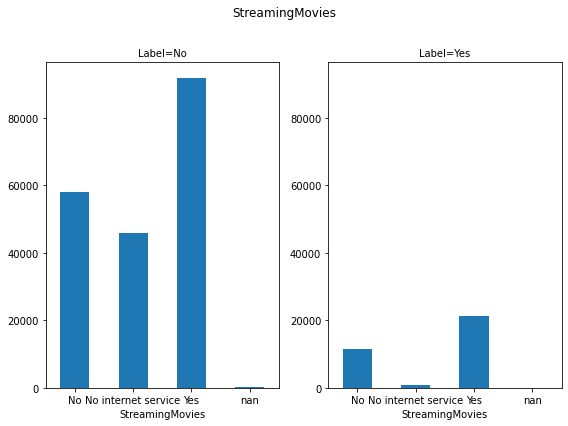

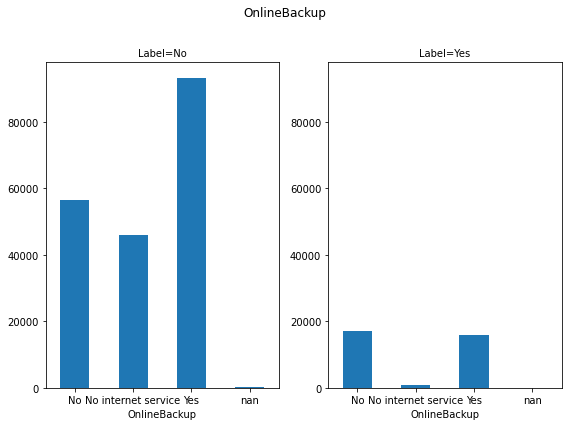

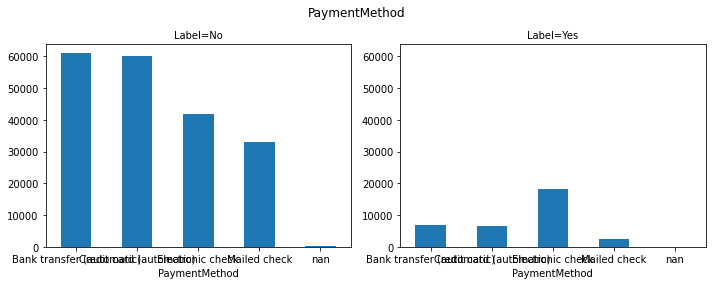

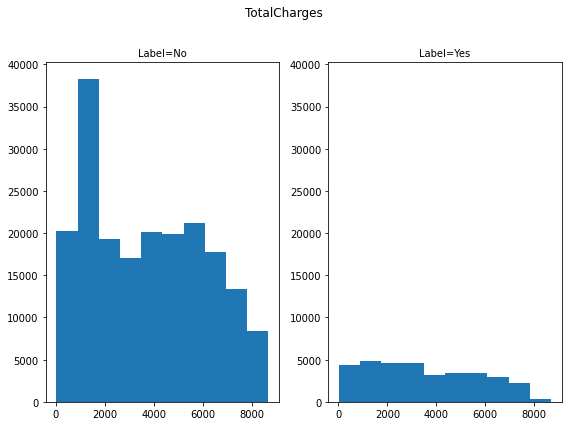

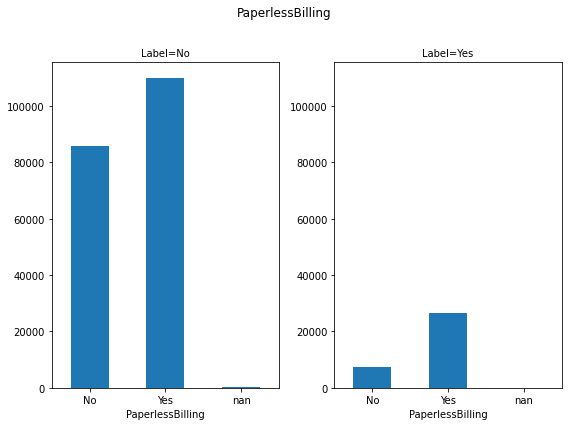

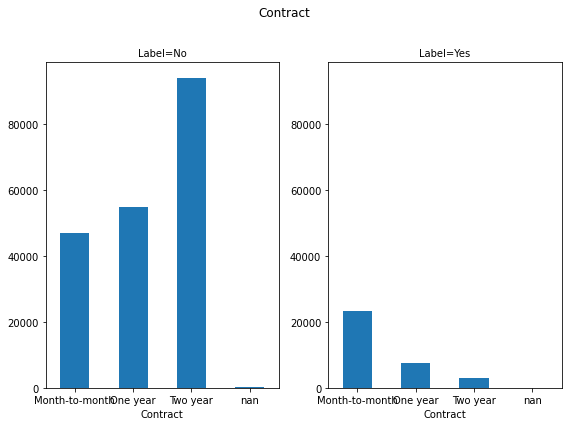

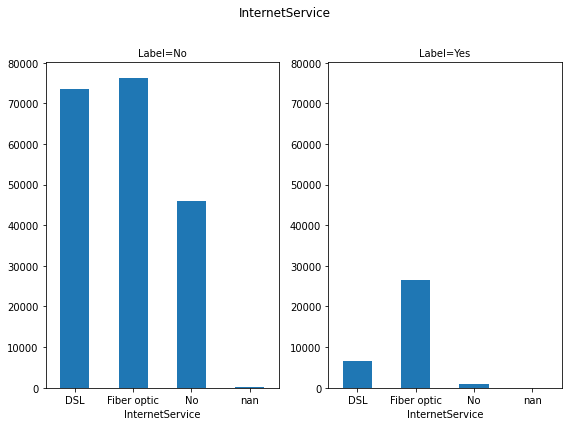

In [ ]:
hdf.stratify(['Label']).cols['gender'].hist(figsize=(10, 4))
hdf.stratify(['Label']).cols['Dependents'].hist(figsize=(10, 4))
hdf.stratify(['Label']).cols['PhoneService'].hist(figsize=(10, 4))
hdf.stratify(['Label']).cols['StreamingMovies'].hist(figsize=(8, 6))
hdf.stratify(['Label']).cols['OnlineBackup'].hist(figsize=(8, 6))
hdf.stratify(['Label']).cols['PaymentMethod'].hist(figsize=(10, 4))
hdf.stratify(['Label']).cols['TotalCharges'].hist(figsize=(8, 6))
hdf.stratify(['Label']).cols['PaperlessBilling'].hist(figsize=(8, 6))
hdf.stratify(['Label']).cols['Contract'].hist(figsize=(8, 6))
hdf.stratify(['Label']).cols['InternetService'].hist(figsize=(8, 6))

In [ ]:
hash = FeatureHasher(inputCols=["gender", "SeniorCitizen", "Partner","tenure", "PhoneService", "MultipleLines", "InternetService","OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "Contract","PaymentMethod", "MonthlyCharges", "TotalCharges"],
                       outputCol="features")
hash_org = FeatureHasher(inputCols=["gender", "SeniorCitizen", "Partner", "Dependents","tenure", "PhoneService", "MultipleLines", "InternetService","OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "Contract","PaymentMethod", "MonthlyCharges", "TotalCharges"],
                       outputCol="features")
featurized = hash.transform(data_Pro_2)
featurized_org = hash_org.transform(data)
featurized.show(7, truncate=False)
featurized_org.show(7, truncate=False)

+----------+------+-------------+-------+------+------------+-------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+-------------------------+--------------+------------+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|customerID|gender|SeniorCitizen|Partner|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity     |OnlineBackup       |DeviceProtection   |TechSupport        |StreamingTV        |StreamingMovies    |Contract      |PaymentMethod            |MonthlyCharges|TotalCharges|Label|features                                                                                                                                                                                                  |
+----------+------+-

In [ ]:
featurized=featurized["Label","features","customerID"]
featurized_org=featurized_org["Label","features","customerID"]
featurized.show(7, truncate=False)
featurized_org.show(7, truncate=False)

+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|Label|features                                                                                                                                                                                                  |customerID|
+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|No   |(262144,[20762,35396,40671,74746,119757,139220,143274,144894,180881,190858,190991,196278,203276,218283,222701,241506,246667],[99.05,1.0,1.0,1.0,1.0,1.0,54.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5295.7]) |5331-RGMTT|
|No   |(262144,[7831,20762,35396,62450,72938,74746,139220,143274,144894,190858,190991,196278,203276,205898,22270

In [ ]:
def f(x): 
    if(x == 'Yes'):
       return 1

    else:
       return 0

featurized=featurized.withColumn("label", when(col("Label")=='Yes', 1).otherwise(0))
featurized=featurized.withColumnRenamed("Label","label")
featurized_org=featurized_org.withColumn("label", when(col("Label")=='Yes', 1).otherwise(0))
featurized_org=featurized_org.withColumnRenamed("Label","label")
featurized.show(7)
featurized_org.show(7)

+-----+--------------------+----------+
|label|            features|customerID|
+-----+--------------------+----------+
|    0|(262144,[20762,35...|5331-RGMTT|
|    0|(262144,[7831,207...|5161-XEUVX|
|    0|(262144,[7831,205...|0336-PIKEI|
|    0|(262144,[7831,205...|3345-PBBFH|
|    0|(262144,[20762,35...|5067-XJQFU|
|    0|(262144,[20762,40...|4056-QHXHZ|
|    0|(262144,[20762,35...|8028-PNXHQ|
+-----+--------------------+----------+
only showing top 7 rows

+-----+--------------------+----------+
|label|            features|customerID|
+-----+--------------------+----------+
|    0|(262144,[20762,35...|5331-RGMTT|
|    0|(262144,[7831,207...|5161-XEUVX|
|    0|(262144,[7831,205...|0336-PIKEI|
|    0|(262144,[7831,205...|3345-PBBFH|
|    0|(262144,[20762,35...|5067-XJQFU|
|    0|(262144,[20762,40...|4056-QHXHZ|
|    0|(262144,[20762,35...|8028-PNXHQ|
+-----+--------------------+----------+
only showing top 7 rows



In [ ]:
train, test = featurized.randomSplit(weights=[0.75,0.25], seed=150)
train_org, test_org = featurized_org.randomSplit(weights=[0.75,0.25], seed=150)
train.show(7)
test.show(7)

+-----+--------------------+----------+
|label|            features|customerID|
+-----+--------------------+----------+
|    0|(262144,[4236,783...|2162-FRZAA|
|    0|(262144,[4236,783...|2162-FRZAA|
|    0|(262144,[4236,783...|2162-FRZAA|
|    0|(262144,[4236,783...|2162-FRZAA|
|    0|(262144,[4236,783...|2162-FRZAA|
|    0|(262144,[4236,783...|2162-FRZAA|
|    0|(262144,[4236,783...|2162-FRZAA|
+-----+--------------------+----------+
only showing top 7 rows

+-----+--------------------+----------+
|label|            features|customerID|
+-----+--------------------+----------+
|    0|(262144,[4236,783...|2162-FRZAA|
|    0|(262144,[4236,783...|2162-FRZAA|
|    0|(262144,[4236,783...|2162-FRZAA|
|    0|(262144,[4236,783...|2162-FRZAA|
|    0|(262144,[4236,783...|2162-FRZAA|
|    0|(262144,[4236,783...|9286-BHDQG|
|    0|(262144,[4236,783...|9286-BHDQG|
+-----+--------------------+----------+
only showing top 7 rows



In [ ]:
logire=LogisticRegression(maxIter=2000,regParam=0.0000002,) 
logire.explainParams()

"aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)\nelasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)\nfamily: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)\nfeaturesCol: features column name. (default: features)\nfitIntercept: whether to fit an intercept term. (default: True)\nlabelCol: label column name. (default: label)\nlowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)\nlowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The bounds vector size must be

In [ ]:
model1=logire.fit(train)
model_main=logire.fit(train_org)

In [ ]:
predictions=model1.transform(test)
predictions_main=model_main.transform(test_org)
predictions.show(10)
predictions_main.show(10)

+-----+--------------------+----------+--------------------+-----------+----------+
|label|            features|customerID|       rawPrediction|probability|prediction|
+-----+--------------------+----------+--------------------+-----------+----------+
|    0|(262144,[4236,783...|2162-FRZAA|[Infinity,-Infinity]|  [1.0,0.0]|       0.0|
|    0|(262144,[4236,783...|2162-FRZAA|[Infinity,-Infinity]|  [1.0,0.0]|       0.0|
|    0|(262144,[4236,783...|2162-FRZAA|[Infinity,-Infinity]|  [1.0,0.0]|       0.0|
|    0|(262144,[4236,783...|2162-FRZAA|[Infinity,-Infinity]|  [1.0,0.0]|       0.0|
|    0|(262144,[4236,783...|2162-FRZAA|[Infinity,-Infinity]|  [1.0,0.0]|       0.0|
|    0|(262144,[4236,783...|9286-BHDQG|[Infinity,-Infinity]|  [1.0,0.0]|       0.0|
|    0|(262144,[4236,783...|9286-BHDQG|[Infinity,-Infinity]|  [1.0,0.0]|       0.0|
|    0|(262144,[4236,783...|9286-BHDQG|[Infinity,-Infinity]|  [1.0,0.0]|       0.0|
|    0|(262144,[4236,783...|9286-BHDQG|[Infinity,-Infinity]|  [1.0,0.0]|    

In [ ]:
predictions.groupBy('label', 'prediction').count().show()
predictions_main.groupBy('label', 'prediction').count().show()
TN = predictions.filter('prediction = 0 AND label = prediction').count()
TP = predictions.filter('prediction = 1 AND label = prediction').count()
FN = predictions.filter('prediction = 0 AND label = 1').count()
FP = predictions.filter('prediction = 1 AND label = 0').count()
TN_main = predictions_main.filter('prediction = 0 AND label = prediction').count()
TP_main = predictions_main.filter('prediction = 1 AND label = prediction').count()
FN_main = predictions_main.filter('prediction = 0 AND label = 1').count()
FP_main = predictions_main.filter('prediction = 1 AND label = 0').count()
accuracy = (TN + TP) / (TN + TP + FN + FP)
accuracy_main = (TN_main + TP_main) / (TN_main + TP_main + FN_main + FP_main)

print("Accuracy  with preprocess data is:",accuracy)
print("Accuracy  main  data is:",accuracy_main)

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    0|       0.0|57321|
+-----+----------+-----+

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    0|       0.0|57404|
+-----+----------+-----+

Accuracy  with preprocess data is: 1.0
Accuracy  main  data is: 1.0
